**Байесовский классификатор: линейный дискриминант Фишера**

Евгений Борисов <esborisov@sevsu.ru>

---

## библиотеки

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##  загружаем данные 

In [2]:
n_samples = 500
n_cls = 2

In [4]:
from sklearn.datasets import make_blobs

X,y = make_blobs( 
        n_samples=n_samples,
        centers=n_cls,  
        cluster_std=[1.0, 2.5,]
    )


lmbd = [ 1.1, 1.1, ]  # коэффициент "цены" ошибки

---

In [5]:
X.shape, y.shape

((500, 2), (500,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5,)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

In [7]:
%xdel X
%xdel y

---

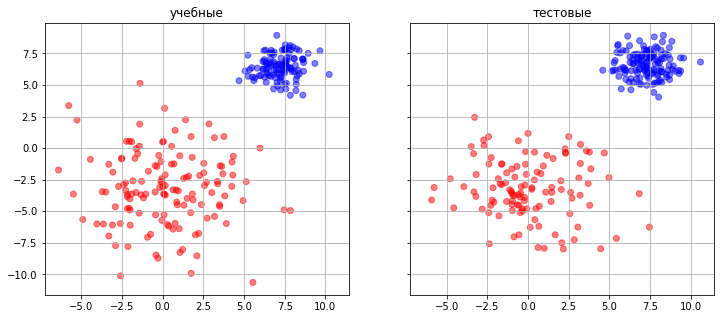

In [8]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
    
c = [ ['b','r','g','y'][j] for j in y_train  ]
axarr[0].set_title('учебные')
axarr[0].scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r','g','y'][j] for j in y_test  ]
axarr[1].set_title('тестовые')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()

##  классификатор

$ 
a(x) = \underset{y\in Y}{\operatorname{argmax}} 
\left[ \ln(\lambda_y P_y) - \frac{1}{2} \mu_y \Sigma^{-1} \mu_y^T + x \Sigma^{-1} \mu_y^T \right] 
$

In [9]:
# априорные вероятности классов
Py = np.asarray([ (y_train==c).sum() for c in sorted(set(y_train)) ])
Py = Py/Py.sum()
Py

array([0.448, 0.552])

In [10]:
# мат.ожидания классов
mu = np.vstack([ X_train[y_train==y,:].mean(axis=0) for y in set(y_train) ] )
mu

array([[ 7.20895584,  6.44404402],
       [ 0.17727314, -3.21381205]])

In [11]:
S = np.cov(X_train.T) # общая матрица матрица ковариаций классов
iS = np.linalg.inv(S) # обратная матрица ковариаций классов

In [12]:
def bayes_score(X,mu,iS,lmbd):
    return np.vstack([ 
       np.log(lmbd[i]*Py[i]) - 0.5* mu[i,:].dot(iS).dot(mu[i,:].T) + X.dot(iS).dot(mu[i,:].T) 
       for i in range(mu.shape[0])
    ])

In [13]:
def bayes(X,mu,iS,lmbd):
    return np.argmax( bayes_score(X,mu,iS,lmbd) ,axis=0)

##  результаты теста

In [14]:
o = bayes(X_test,mu,iS,lmbd)

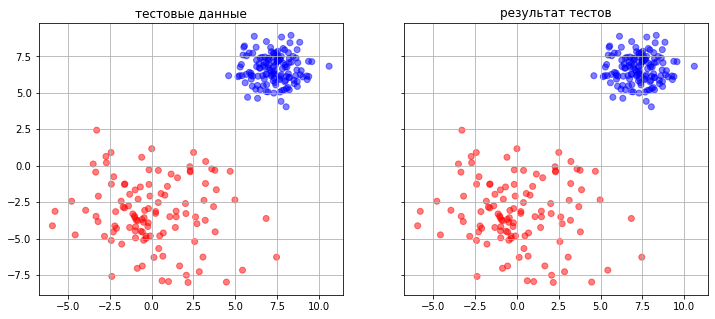

In [15]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
    
c = [ ['b','r','g','y'][j] for j in y_test  ]

axarr[0].set_title('тестовые данные')
axarr[0].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r','g','y'][j] for j in o  ]
axarr[1].set_title('результат тестов')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()


## метрики качества

In [16]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       112

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [17]:
cm = confusion_matrix(y_test,o)

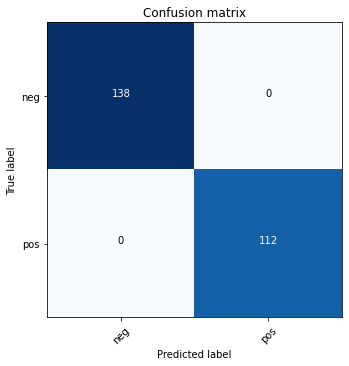

In [18]:
classes = ['neg','pos'] if n_cls<3 else list(range(n_cls))
tick_marks = np.arange(len(classes))

plt.figure(figsize=(5,5))


plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

# # plt.colorbar()


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()